In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *

spark = (
    SparkSession.builder.appName("ADS project 2")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.executor.memory", "2g")
    .config("spark.driver.memory", "4g")
    .getOrCreate()
)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/09/18 21:12:46 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
import os

data_loc = "../data/tables/"
consumer = spark.read.parquet(data_loc+"consumer_user_details.parquet")
tbl_consumer = spark.read.csv(data_loc+"tbl_consumer.csv", sep="|", header=True)
tbl_merchant = spark.read.parquet(data_loc+"tbl_merchants.parquet")
transactions = [data_loc + i + "/" for i in os.listdir(data_loc) if "transactions" in i]
print(transactions)
transact = spark.read.parquet('../data/tables/transactions_20210228_20210827_snapshot/')
transact = transact.union(spark.read.parquet('../data/tables/transactions_20220228_20220828_snapshot/'))
transact = transact.union(spark.read.parquet('../data/tables/transactions_20210828_20220227_snapshot/'))

['../data/tables/transactions_20210228_20210827_snapshot/', '../data/tables/transactions_20220228_20220828_snapshot/', '../data/tables/transactions_20210828_20220227_snapshot/']


<h2> 1. Standardize column format of tables</h2>

<h3>1.1 "tbl_merchants.parquet"</h3>

In [3]:
tbl_merchant.show(5)

+--------------------+--------------------+------------+
|                name|                tags|merchant_abn|
+--------------------+--------------------+------------+
|       Felis Limited|((furniture, home...| 10023283211|
|Arcu Ac Orci Corp...|([cable, satellit...| 10142254217|
|    Nunc Sed Company|([jewelry, watch,...| 10165489824|
|Ultricies Digniss...|([wAtch, clock, a...| 10187291046|
| Enim Condimentum PC|([music shops - m...| 10192359162|
+--------------------+--------------------+------------+
only showing top 5 rows



In [4]:
# separate "tags" into "products", "revenue_level", "take_rate"
preprocessed_tbl_merchant = tbl_merchant.withColumn("split_tags", split(col("tags"), ",")) \
            .withColumn("take_rate", element_at(col("split_tags"), -1)) \
            .withColumn("revenue_level", element_at(col("split_tags"), -2)) \
            .withColumn("products", slice(reverse(col("split_tags")), 3, 100)) \
            .withColumn("products", reverse(col("products")))


In [5]:
# remove the special characters of "revenue_level" and "take_rate"
preprocessed_tbl_merchant = preprocessed_tbl_merchant.withColumn("revenue_level", regexp_replace("revenue_level", "[^a-e]", "")) \
                                                     .withColumn("take_rate", regexp_replace("take_rate", "[^0-9.]", ""))

In [6]:
# standardize the values in "products" and vectorize "products" into the bags of word
preprocessed_tbl_merchant = preprocessed_tbl_merchant.withColumn("products", concat_ws(",", col("products"))) \
                                                     .withColumn("products", regexp_replace("products", "[^A-Za-z0-9]", " ")) \
                                                     .withColumn("products", regexp_replace("products", "\s+", " ")) \
                                                     .withColumn("products", regexp_replace("products", "(^\s+)|(\s+$)", "")) \
                                                     .withColumn("products", lower(col("products"))) \
                                                    #  .withColumn("products", split(col("products"), " "))

In [7]:
preprocessed_tbl_merchant = preprocessed_tbl_merchant.withColumnRenamed("name", "merchant_name")
preprocessed_tbl_merchant = preprocessed_tbl_merchant.select("merchant_name", "products", "revenue_level",
                                                             preprocessed_tbl_merchant.take_rate.cast("double"), "merchant_abn")

In [8]:
preprocessed_tbl_merchant.show(5)

+--------------------+--------------------+-------------+---------+------------+
|       merchant_name|            products|revenue_level|take_rate|merchant_abn|
+--------------------+--------------------+-------------+---------+------------+
|       Felis Limited|furniture home fu...|            e|     0.18| 10023283211|
|Arcu Ac Orci Corp...|cable satellite a...|            b|     4.22| 10142254217|
|    Nunc Sed Company|jewelry watch clo...|            b|      4.4| 10165489824|
|Ultricies Digniss...|watch clock and j...|            b|     3.29| 10187291046|
| Enim Condimentum PC|music shops music...|            a|     6.33| 10192359162|
+--------------------+--------------------+-------------+---------+------------+
only showing top 5 rows



In [9]:
tags = preprocessed_tbl_merchant.rdd.map(lambda x: x[1]).collect()
tags_unique = " ".join(tags).split()
tags_unique = list(set(tags_unique))
print(len(tags_unique)) # not too many, can check some by hand, e.g. 'except' is the only word that has negative meaning
tags_unique

95


['card',
 'artist',
 'antique',
 'spas',
 'stock',
 'jewelry',
 'motor',
 'galleries',
 'satellite',
 'radio',
 'software',
 'computer',
 'writing',
 'musical',
 'new',
 'repairs',
 'including',
 'manufacturers',
 'service',
 'cable',
 'toy',
 'office',
 'shops',
 'newspapers',
 'art',
 'game',
 'printing',
 'furnishings',
 'souvenir',
 'sheet',
 'vehicle',
 'pianos',
 'appliance',
 'programming',
 'al',
 'integrated',
 'craft',
 'instruments',
 'clock',
 'lawn',
 'tent',
 'paper',
 'florists',
 'goods',
 'eyeglasses',
 'beauty',
 'services',
 'shoe',
 'dealers',
 'parts',
 'silverware',
 'hobby',
 'periodicals',
 'repair',
 'garden',
 'leasing',
 'furniture',
 'rent',
 'except',
 'nursery',
 'design',
 'home',
 'nurseries',
 'pay',
 'telecom',
 'equipment',
 'bicycle',
 'other',
 'data',
 'gift',
 'sales',
 'systems',
 'flowers',
 'health',
 'restoration',
 'appliances',
 'processing',
 'computers',
 'supplies',
 'and',
 'watch',
 'awning',
 'novelty',
 'stationery',
 'digital',
 'sup

In [10]:
for i in range(len(tags)):
    tags[i] = tags[i].split()
    cur = [tags[i][0]]
    for j in range(1, len(tags[i])):
        if tags[i][j-1] != "except":
            if tags[i][j] != "and" and tags[i][j] != "except" and tags[i][j] != "other" and tags[i][j] != "shops":
                cur += [tags[i][j]]
    tags[i] = cur
# tags

In [11]:
from pyspark.sql.types import *

@udf(ArrayType(StringType()))
def tokenise(tag):
    tag = tag.split()
    cur = [tag[0]]
    for i in range(1, len(tag)):
        if tag[i-1] != "except":
            if tag[i] not in ["and", "except", "other", "shops"]:
                cur += [tag[i]]
    return cur

In [12]:
preprocessed_tbl_merchant_token = preprocessed_tbl_merchant.withColumn("tag", tokenise(col("products")))
preprocessed_tbl_merchant_token

merchant_name,products,revenue_level,take_rate,merchant_abn,tag
Felis Limited,furniture home fu...,e,0.18,10023283211,"[furniture, home,..."
Arcu Ac Orci Corp...,cable satellite a...,b,4.22,10142254217,"[cable, satellite..."
Nunc Sed Company,jewelry watch clo...,b,4.4,10165489824,"[jewelry, watch, ..."
Ultricies Digniss...,watch clock and j...,b,3.29,10187291046,"[watch, clock, je..."
Enim Condimentum PC,music shops music...,a,6.33,10192359162,"[music, musical, ..."
Fusce Company,gift card novelty...,a,6.34,10206519221,"[gift, card, nove..."
Aliquam Enim Inco...,computers compute...,b,4.32,10255988167,"[computers, compu..."
Ipsum Primis Ltd,watch clock and j...,c,2.39,10264435225,"[watch, clock, je..."
Pede Ultrices Ind...,computer programm...,a,5.71,10279061213,"[computer, progra..."
Nunc Inc.,furniture home fu...,a,6.61,10323485998,"[furniture, home,..."


In [37]:
from pyspark.ml.feature import HashingTF, IDF, Tokenizer

hashingTF = HashingTF(inputCol="tag", outputCol="features", numFeatures=20)
preprocessed_tbl_merchant_bow = hashingTF.transform(preprocessed_tbl_merchant_token)
preprocessed_tbl_merchant_bow

merchant_name,products,revenue_level,take_rate,merchant_abn,tag,features
Felis Limited,furniture home fu...,e,0.18,10023283211,"[furniture, home,...","(20,[3,5,6,12,13]..."
Arcu Ac Orci Corp...,cable satellite a...,b,4.22,10142254217,"[cable, satellite...","(20,[6,7,13,16,17..."
Nunc Sed Company,jewelry watch clo...,b,4.4,10165489824,"[jewelry, watch, ...","(20,[8,9,17,18],[..."
Ultricies Digniss...,watch clock and j...,b,3.29,10187291046,"[watch, clock, je...","(20,[2,8,17,18],[..."
Enim Condimentum PC,music shops music...,a,6.33,10192359162,"[music, musical, ...","(20,[3,5,6,10,18]..."
Fusce Company,gift card novelty...,a,6.34,10206519221,"[gift, card, nove...","(20,[4,14,18],[1...."
Aliquam Enim Inco...,computers compute...,b,4.32,10255988167,"[computers, compu...","(20,[3,4,6,11,13]..."
Ipsum Primis Ltd,watch clock and j...,c,2.39,10264435225,"[watch, clock, je...","(20,[2,8,17,18],[..."
Pede Ultrices Ind...,computer programm...,a,5.71,10279061213,"[computer, progra...","(20,[1,2,6,9,11,1..."
Nunc Inc.,furniture home fu...,a,6.61,10323485998,"[furniture, home,...","(20,[3,5,6,12,13]..."


In [39]:
from pyspark.ml.clustering import KMeans

kmeans = KMeans(k=5)
model = kmeans.fit(preprocessed_tbl_merchant_bow.select("features"))
preprocessed_tbl_merchant_cat = model.transform(preprocessed_tbl_merchant_bow)
preprocessed_tbl_merchant_cat = preprocessed_tbl_merchant_cat.select("merchant_name", "products", "revenue_level", "take_rate", "merchant_abn", col("prediction").alias("category"))
preprocessed_tbl_merchant_cat

merchant_name,products,revenue_level,take_rate,merchant_abn,category
Felis Limited,furniture home fu...,e,0.18,10023283211,1
Arcu Ac Orci Corp...,cable satellite a...,b,4.22,10142254217,4
Nunc Sed Company,jewelry watch clo...,b,4.4,10165489824,4
Ultricies Digniss...,watch clock and j...,b,3.29,10187291046,4
Enim Condimentum PC,music shops music...,a,6.33,10192359162,1
Fusce Company,gift card novelty...,a,6.34,10206519221,0
Aliquam Enim Inco...,computers compute...,b,4.32,10255988167,1
Ipsum Primis Ltd,watch clock and j...,c,2.39,10264435225,4
Pede Ultrices Ind...,computer programm...,a,5.71,10279061213,2
Nunc Inc.,furniture home fu...,a,6.61,10323485998,1


<h3>1.2 "transactions_20210228_20210827_snapshot"</h3>

In [40]:
transact.show(5)

+-------+------------+------------------+--------------------+--------------+
|user_id|merchant_abn|      dollar_value|            order_id|order_datetime|
+-------+------------+------------------+--------------------+--------------+
|  18478| 62191208634|63.255848959735246|949a63c8-29f7-4ab...|    2021-08-20|
|      2| 15549624934| 130.3505283105634|6a84c3cf-612a-457...|    2021-08-20|
|  18479| 64403598239|120.15860593212783|b10dcc33-e53f-425...|    2021-08-20|
|      3| 60956456424| 136.6785200286976|0f09c5a5-784e-447...|    2021-08-20|
|  18479| 94493496784| 72.96316578355305|f6c78c1a-4600-4c5...|    2021-08-20|
+-------+------------+------------------+--------------------+--------------+
only showing top 5 rows



In [41]:
# separate pickup datetime into date, year, month and day
preprocessed_transact = transact.withColumn('order_year', year(col('order_datetime')))
preprocessed_transact = preprocessed_transact.withColumn('order_month', month(col('order_datetime')))
preprocessed_transact = preprocessed_transact.withColumn('order_day', dayofmonth(col('order_datetime')))
preprocessed_transact = preprocessed_transact.withColumnRenamed('merchant_abn', 'merchant_abn_repeat')

In [42]:
preprocessed_transact.show(5)

+-------+-------------------+------------------+--------------------+--------------+----------+-----------+---------+
|user_id|merchant_abn_repeat|      dollar_value|            order_id|order_datetime|order_year|order_month|order_day|
+-------+-------------------+------------------+--------------------+--------------+----------+-----------+---------+
|  18478|        62191208634|63.255848959735246|949a63c8-29f7-4ab...|    2021-08-20|      2021|          8|       20|
|      2|        15549624934| 130.3505283105634|6a84c3cf-612a-457...|    2021-08-20|      2021|          8|       20|
|  18479|        64403598239|120.15860593212783|b10dcc33-e53f-425...|    2021-08-20|      2021|          8|       20|
|      3|        60956456424| 136.6785200286976|0f09c5a5-784e-447...|    2021-08-20|      2021|          8|       20|
|  18479|        94493496784| 72.96316578355305|f6c78c1a-4600-4c5...|    2021-08-20|      2021|          8|       20|
+-------+-------------------+------------------+--------

<h3>1.3 "tbl_consumer.csv"</h3>

In [43]:
tbl_consumer.show(5)

+-----------------+--------------------+-----+--------+------+-----------+
|             name|             address|state|postcode|gender|consumer_id|
+-----------------+--------------------+-----+--------+------+-----------+
| Yolanda Williams|413 Haney Gardens...|   WA|    6935|Female|    1195503|
|       Mary Smith|     3764 Amber Oval|  NSW|    2782|Female|     179208|
|    Jill Jones MD|  40693 Henry Greens|   NT|     862|Female|    1194530|
|  Lindsay Jimenez|00653 Davenport C...|  NSW|    2780|Female|     154128|
|Rebecca Blanchard|9271 Michael Mano...|   WA|    6355|Female|     712975|
+-----------------+--------------------+-----+--------+------+-----------+
only showing top 5 rows



In [44]:
preprocessed_tbl_consumer = tbl_consumer.withColumnRenamed("name", "consumer")
preprocessed_tbl_consumer = preprocessed_tbl_consumer.withColumnRenamed("address", "consumer_address")
preprocessed_tbl_consumer = preprocessed_tbl_consumer.withColumnRenamed("state", "consumer_state")
preprocessed_tbl_consumer = preprocessed_tbl_consumer.withColumnRenamed("postcode", "consumer_postcode")
preprocessed_tbl_consumer = preprocessed_tbl_consumer.withColumnRenamed("gender", "consumer_gender")

In [45]:
preprocessed_tbl_consumer.show(5)

+-----------------+--------------------+--------------+-----------------+---------------+-----------+
|         consumer|    consumer_address|consumer_state|consumer_postcode|consumer_gender|consumer_id|
+-----------------+--------------------+--------------+-----------------+---------------+-----------+
| Yolanda Williams|413 Haney Gardens...|            WA|             6935|         Female|    1195503|
|       Mary Smith|     3764 Amber Oval|           NSW|             2782|         Female|     179208|
|    Jill Jones MD|  40693 Henry Greens|            NT|              862|         Female|    1194530|
|  Lindsay Jimenez|00653 Davenport C...|           NSW|             2780|         Female|     154128|
|Rebecca Blanchard|9271 Michael Mano...|            WA|             6355|         Female|     712975|
+-----------------+--------------------+--------------+-----------------+---------------+-----------+
only showing top 5 rows



<h3>1.4 "consumer.parquet"</h3>

In [46]:
consumer.show(5)

+-------+-----------+
|user_id|consumer_id|
+-------+-----------+
|      1|    1195503|
|      2|     179208|
|      3|    1194530|
|      4|     154128|
|      5|     712975|
+-------+-----------+
only showing top 5 rows



In [47]:
preprocessed_consumer = consumer.withColumnRenamed("user_id", "user_id_repeat")
preprocessed_consumer = preprocessed_consumer.withColumnRenamed("consumer_id", "consumer_id_repeat")

In [48]:
preprocessed_consumer.show(5)

+--------------+------------------+
|user_id_repeat|consumer_id_repeat|
+--------------+------------------+
|             1|           1195503|
|             2|            179208|
|             3|           1194530|
|             4|            154128|
|             5|            712975|
+--------------+------------------+
only showing top 5 rows



<h2>2. Join tables</h2>

In [49]:
preprocessed_tbl_merchant_cat.createOrReplaceTempView('merchant')
preprocessed_transact.createOrReplaceTempView('transact')
preprocessed_tbl_consumer.createOrReplaceTempView('tbl_consumer')
preprocessed_consumer.createOrReplaceTempView('consumer')

join = spark.sql("""
SELECT 
    *
FROM 
    merchant
INNER JOIN
    transact
ON 
    transact.merchant_abn_repeat = merchant.merchant_abn
INNER JOIN
    consumer
ON
    transact.user_id = consumer.user_id_repeat
INNER JOIN
    tbl_consumer
ON 
    consumer.consumer_id_repeat = tbl_consumer.consumer_id
ORDER BY
    revenue_level DESC
""")

join = join.drop("merchant_abn_repeat", "consumer_id_repeat", "user_id_repeat", "merchant_abn", "consumer_id", "user_id", "order_id", "order_datetime")
print(f"Mismatched (null) transactions dropped: {preprocessed_transact.count() - join.count()}")

Mismatched (null) transactions dropped: 580830


In [50]:
join

merchant_name,products,revenue_level,take_rate,category,dollar_value,order_year,order_month,order_day,consumer,consumer_address,consumer_state,consumer_postcode,consumer_gender
Metus Sit Amet In...,cable satellite a...,e,0.38,4,39.75699971405571,2022,1,29,Joseph Allen,5872 Nicole Knoll...,SA,5291,Male
Dis Parturient Co...,gift card novelty...,e,0.24,0,112.74041721557072,2022,7,4,Aaron Harvey,35273 Powell Over...,TAS,7171,Male
Nunc Est LLP,watch clock and j...,e,0.22,4,170.2571495605144,2021,5,21,Christopher Patte...,701 Rivers Pine,VIC,3882,Undisclosed
Risus Nulla Insti...,bicycle shops sal...,e,0.22,4,25.33663463383725,2022,10,19,Zachary Evans,947 Mclaughlin Ra...,NSW,2293,Male
Augue Eu Tempor A...,cable satellite a...,e,0.38,4,68.52164340358037,2021,12,22,Christopher Patte...,701 Rivers Pine,VIC,3882,Undisclosed
Felis Limited,furniture home fu...,e,0.18,1,102.62436872103531,2022,8,10,Christopher Walsh,223 Heather Fort,QLD,4705,Male
Magna Sed Institute,cable satellite a...,e,0.31,4,205.72634468281439,2022,7,30,Kenneth Tran,480 Blanchard Land,WA,6915,Male
Et Nunc Consulting,books periodicals...,e,0.16,0,318.7462897182931,2022,5,9,Joseph Allen,5872 Nicole Knoll...,SA,5291,Male
Dis Parturient Co...,gift card novelty...,e,0.24,0,101.8556586370564,2022,7,25,Kenneth Tran,480 Blanchard Land,WA,6915,Male
Nunc Est LLP,watch clock and j...,e,0.22,4,74.24813966310627,2022,4,21,Joseph Allen,5872 Nicole Knoll...,SA,5291,Male


<h2>3. Outlier removal</h2>

<h3>3.1 Get distribution for each revenue level</h3>

<AxesSubplot:xlabel='dollar_value', ylabel='revenue_level'>

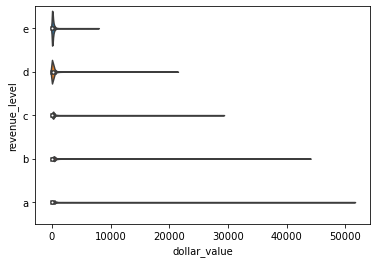

In [26]:
import seaborn as sns
sns.violinplot(data=join.sample(False, 0.1).toPandas(), x="dollar_value", y="revenue_level")

<AxesSubplot:xlabel='dollar_value', ylabel='revenue_level'>

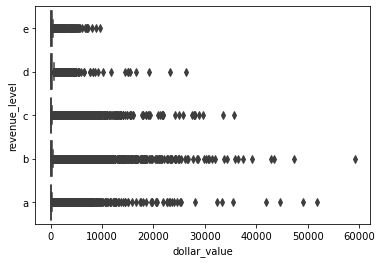

In [27]:
sns.boxplot(data=join.sample(False, 0.1).toPandas(), x="dollar_value", y="revenue_level")

<h4>3.1.1 Remove outliers based on standard deviation</h4>

In [51]:
rev_std = (join.groupBy("revenue_level").agg(stddev_pop("dollar_value").alias("dollar_value_std"),
                                             avg("dollar_value").alias("dollar_value_mean")))
rev_std

revenue_level,dollar_value_std,dollar_value_mean
e,399.0613152439408,205.8121276388132
d,681.0178374382781,272.26155837560833
c,434.4194205501614,136.49983808642475
b,594.2473799043438,197.1016706119255
a,360.36435354274346,142.08113719400276


In [52]:
total = join.count()
rev_sdf = (join.join(rev_std, "revenue_level", "left")
               .filter(abs(col("dollar_value") - col("dollar_value_mean")) <= 3 * col("dollar_value_std"))
               .drop("dollar_value_mean")
               .drop("dollar_value_std"))
print(f"Outliers based on revenue band removed: {total - rev_sdf.count()}")

Outliers based on revenue band removed: 136394


<h4>3.1.2 Check distribution</h4>

22/09/18 21:17:13 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


<AxesSubplot:xlabel='dollar_value', ylabel='revenue_level'>

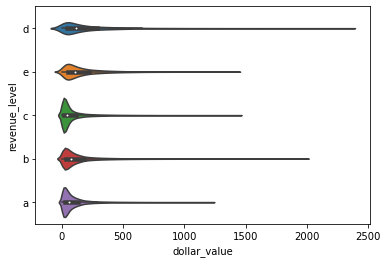

In [30]:
sns.violinplot(data=rev_sdf.sample(False, 0.1).toPandas(), x="dollar_value", y="revenue_level")

22/09/18 21:18:35 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/18 21:18:35 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/09/18 21:18:35 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


<AxesSubplot:xlabel='dollar_value', ylabel='revenue_level'>

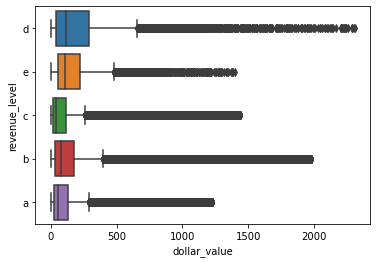

In [31]:
sns.boxplot(data=rev_sdf.sample(False, 0.1).toPandas(), x="dollar_value", y="revenue_level")

<h3>3.2 Get distribution of each merchant</h3>

In [53]:
merch_std = (rev_sdf.groupBy("merchant_name").agg(stddev_pop("dollar_value").alias("dollar_value_std"),
                                                  avg("dollar_value").alias("dollar_value_mean")))
merch_std

22/09/18 21:37:49 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/09/18 21:37:56 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


merchant_name,dollar_value_std,dollar_value_mean
Donec Luctus Indu...,130.5565015716507,343.7164090501804
Elit Company,122.96176805496256,171.59405507134576
Aliquet Odio Ltd,525.5999084080495,989.9594869027516
Et Pede Inc.,354.5044546463389,718.4388984070839
Commodo Auctor Ve...,51.08175002355147,54.94036664642259
Hendrerit Consect...,323.0055122458617,328.12859457680736
Libero Nec Ligula...,287.0373760898241,708.8891167985263
Montes Nascetur Ltd,190.52722125221516,351.7849409696694
Ut Nisi Limited,552.0367734312347,648.2357732269966
Enim Etiam Institute,349.0376849678728,734.5491579179835


In [54]:
total = rev_sdf.count()
merch_sdf = (rev_sdf.join(merch_std, "merchant_name", "left")
                   .filter(abs(col("dollar_value") - col("dollar_value_mean")) <= 3 * col("dollar_value_std"))
                   .drop("dollar_value_mean")
                   .drop("dollar_value_std"))
print(f"Outliers based on merchant removed: {total - merch_sdf.count()}")

22/09/18 21:38:10 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/18 21:38:10 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/18 21:38:10 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/18 21:38:10 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/18 21:38:10 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/18 21:38:10 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/09/18 21:38:10 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/09/18 21:38:12 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/18 21:38:12 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/18 21:38:12 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/09/18 21:38:14 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


Outliers based on merchant removed: 175078


In [56]:
merch_sdf.write.parquet("../data/curated/mechant_consumer_info")

22/09/18 21:38:53 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/18 21:38:53 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/18 21:38:54 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/09/18 21:38:57 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/09/18 21:39:09 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
